# Import
- libraries
- warnings
- colors
- api key
- data load *df* (FRED/NROU: Natural Rate of Unemployment)

In [40]:
import os
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
import statsmodels.api as sm
import warnings


warnings.filterwarnings('ignore')  #show warnings

plt.style.use('fivethirtyeight')  #set color scheme for plt

key = os.environ.get("QUANDL_API")  #set api key from environment variables

# key  # check if key loaded

quandl.ApiConfig.api_key = key #set api for quandl configuration

# FRED/NROU: Natural Rate of Unemployment
df = quandl.get('FRED/NROU')
df.head()#.reset_index(inplace=True)

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


# EDA, Rate of Unemployment
- visuals

<Axes: ylabel='Frequency'>

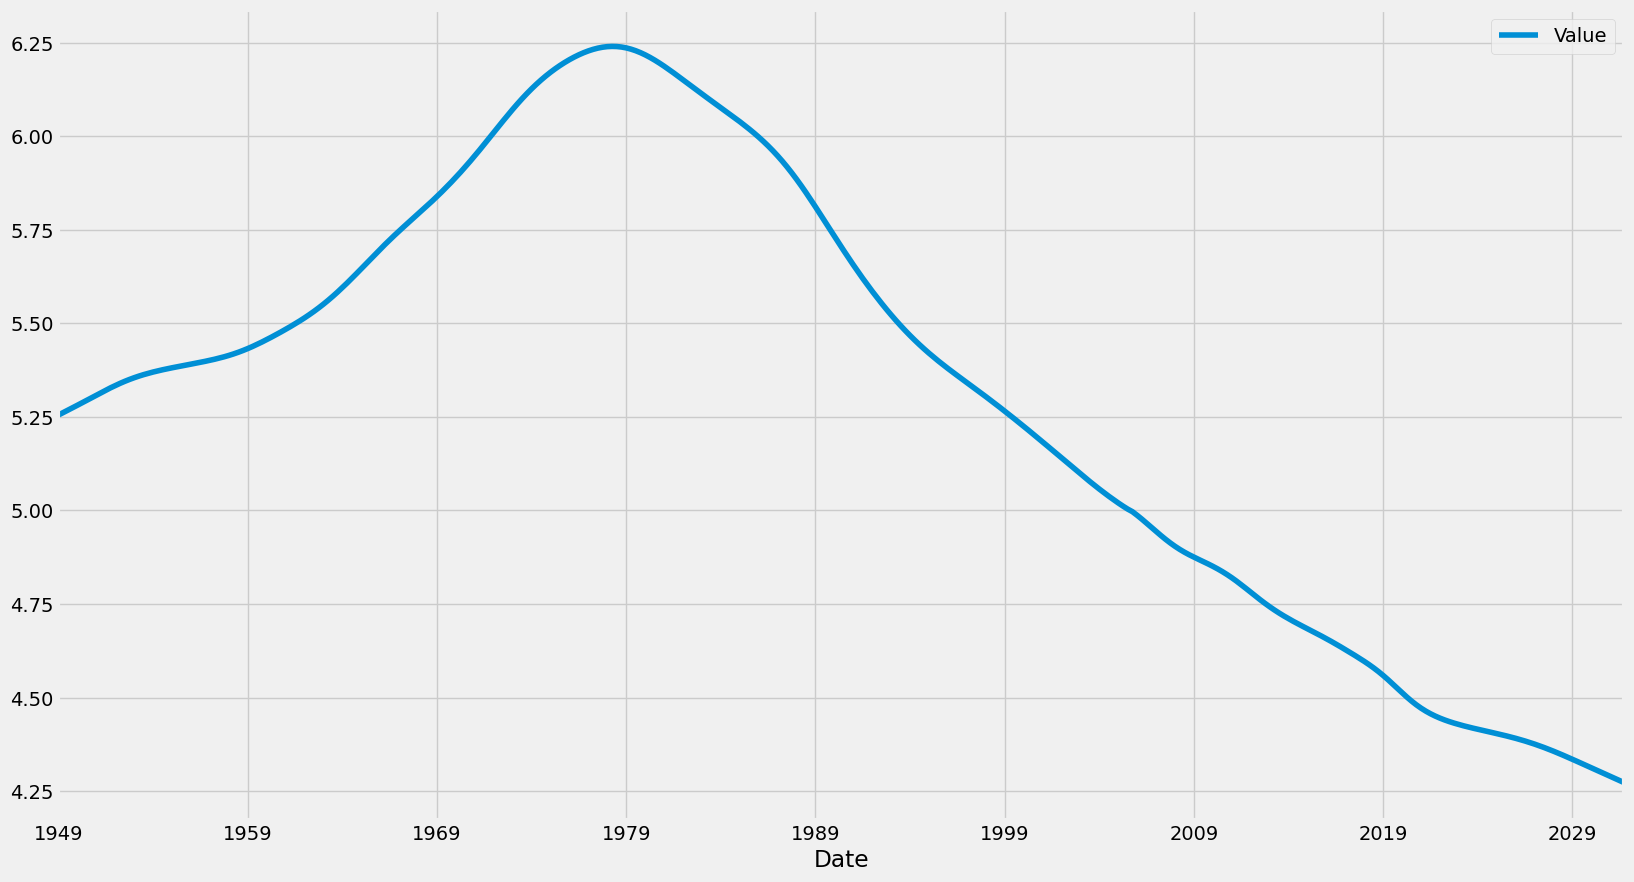

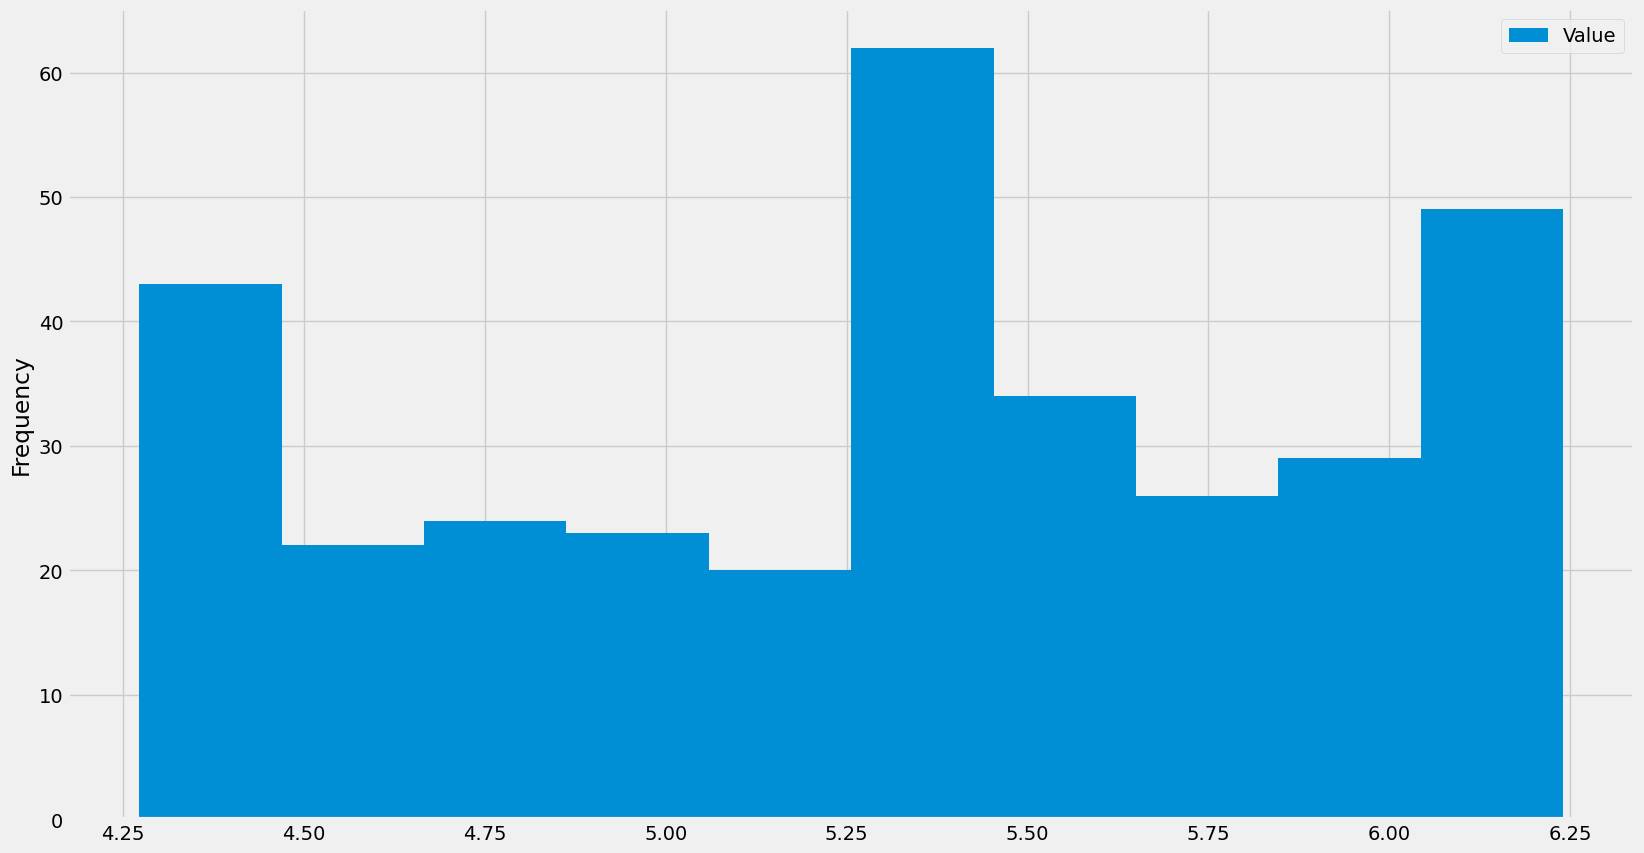

In [41]:
df.plot(kind='line')
df.plot(kind='hist')


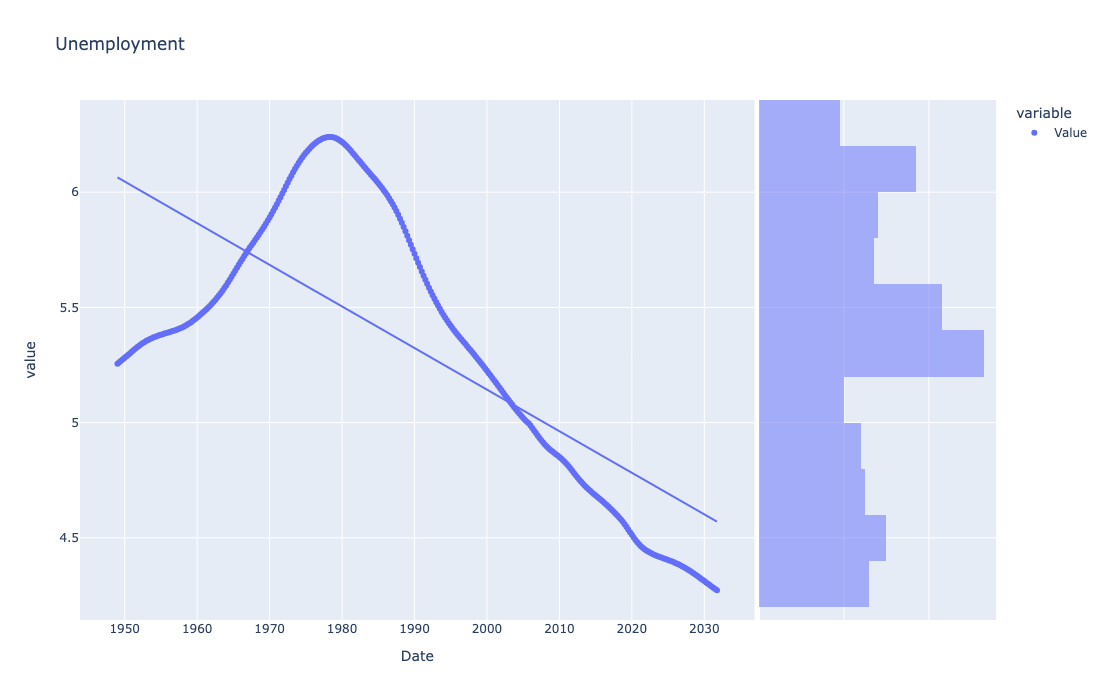

In [42]:
#plotly scatterplots provide multiple charts using marginal_y or _x:
Unemployment = px.scatter(df['Value'], marginal_y='histogram', title='Unemployment', 
                 width=700, height=700, trendline='ols')

Unemployment

Now lets subset the data between 1980-2020

<Axes: title={'center': 'Unemployment: 1980-2020'}, xlabel='datetime'>

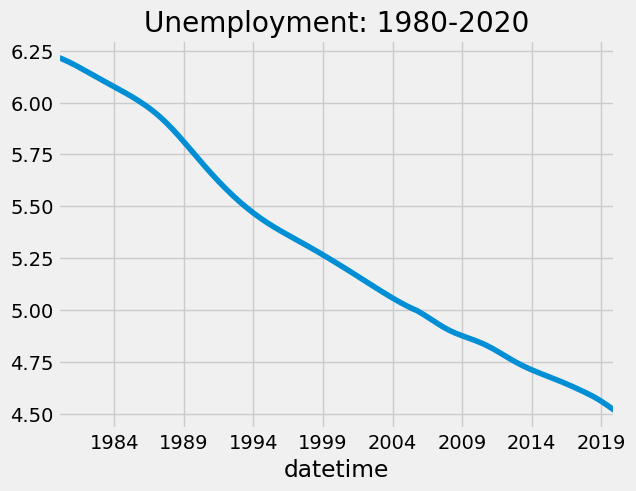

In [5]:
df1 = df.reset_index().query('2020 >= Date >= 1980').copy() #subset data, query > loc i think

df1['datetime'] = pd.to_datetime(df1['Date'])   #set datetime
df1.set_index('datetime', inplace=True)          #set index
df1.drop(columns='Date', axis=1, inplace=True)    #drop old column

df1.plot(kind='line', title='Unemployment: 1980-2020', legend=False) # plot new data


In [6]:
df1.head()

,Value
datetime,
1980-01-01,6.217371
1980-04-01,6.210709
1980-07-01,6.203388
1980-10-01,6.195496
1981-01-01,6.187123


# Decomposition of Data
- decomp()
- - Decomposition of df, default 'additive' model
- dickey_fuller(),
- - Dickey Fuller Test for Stationarity vs Non-Stationarity 

In [15]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 10

#define decomp function
def decomp(df):
    '''
    plot decomposition chart for time series data
    '''
    decomposition = sm.tsa.seasonal_decompose(df, model='additive')
    decomposition.plot()
    plt.show()
    

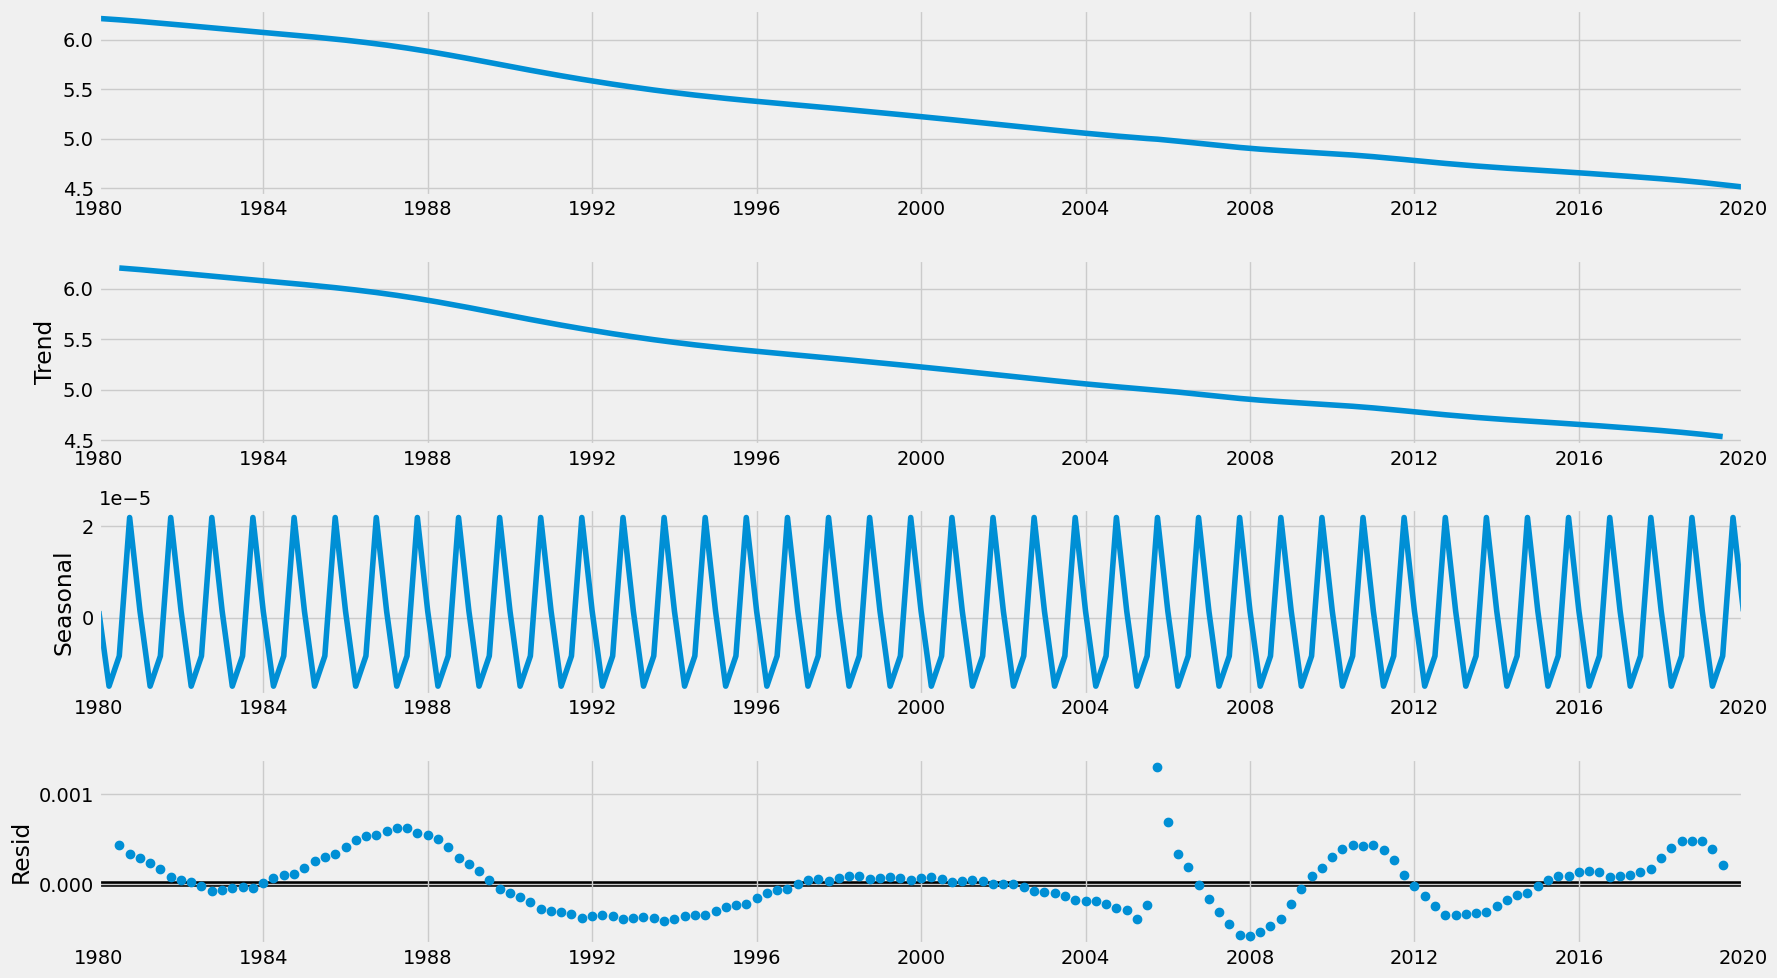

In [16]:
decomp(df1)

In [17]:
from statsmodels.tsa.stattools import adfuller

#define Dickey Fuller function
def dickey_fuller(df):
    '''
    Dickey Fuller statistical test for 
    Stationary vs Non-Stationary time series data
    '''

    result = adfuller(df)  #run test from statsmodels
    
    test_statistic, p_value, lags, nobs, critical_values, icbest = result  # organize the results, name them
    
    df_result = pd.DataFrame({      # Create a DataFrame to display the results
        'Test Statistic': test_statistic,
        'p-value': p_value,
        'Number of Lags': lags,
        'Number of Observations': nobs,
        'Critical Values (1%)': critical_values['1%'],
        'Critical Values (5%)': critical_values['5%'],
        'Critical Values (10%)': critical_values['10%'],
        'IC Best': icbest
    }, index=['Value']).T  #transform df
    
    print("Augmented Dickey-Fuller Test Results:")        # Display the results
    print(df_result, '\n')
                                                           # print easy to read logic
    if p_value < 0.05:
        print(f'p_value ({p_value:.2f}) is less than 0.05')
        if test_statistic < critical_values['5%']:                  
            print(f'Test Statistic ({test_statistic:.2f}) is less than Critical threshold of 5% ({critical_values["5%"]:.2f}). \n\
    \nNull Hypothesis -rejected-, data is -stationary-')
        else:
            print(f'Test Statistic ({test_statistic:.2f}) is greater than Critical threshold of 5% ({critical_values["5%"]:.2f}). \n\
    \nNull Hypothesis -not- rejected, data is -non-stationary-')
    else:
        print(f'p_value ({p_value:.2f}) is greater than 0.05 and statistically not significant.')
 


In [18]:
dickey_fuller(df1)

Augmented Dickey-Fuller Test Results:
                              Value
Test Statistic            -1.536249
p-value                    0.515509
Number of Lags             4.000000
Number of Observations   156.000000
Critical Values (1%)      -3.472979
Critical Values (5%)      -2.880252
Critical Values (10%)     -2.576747
IC Best                -1935.027840 

p_value (0.52) is greater than 0.05 and statistically not significant.


# Stationarizing
- difference(), Differencing
- Log Transformations
- Combinations

In [19]:
#Differencing
def difference(df):    
    
    df_diff = df - df.shift(1)
    
    df_diff.dropna(inplace=True)
    
    return df_diff

Augmented Dickey-Fuller Test Results:
                              Value
Test Statistic            -1.536249
p-value                    0.515509
Number of Lags             4.000000
Number of Observations   156.000000
Critical Values (1%)      -3.472979
Critical Values (5%)      -2.880252
Critical Values (10%)     -2.576747
IC Best                -1935.027840 

p_value (0.52) is greater than 0.05 and statistically not significant.


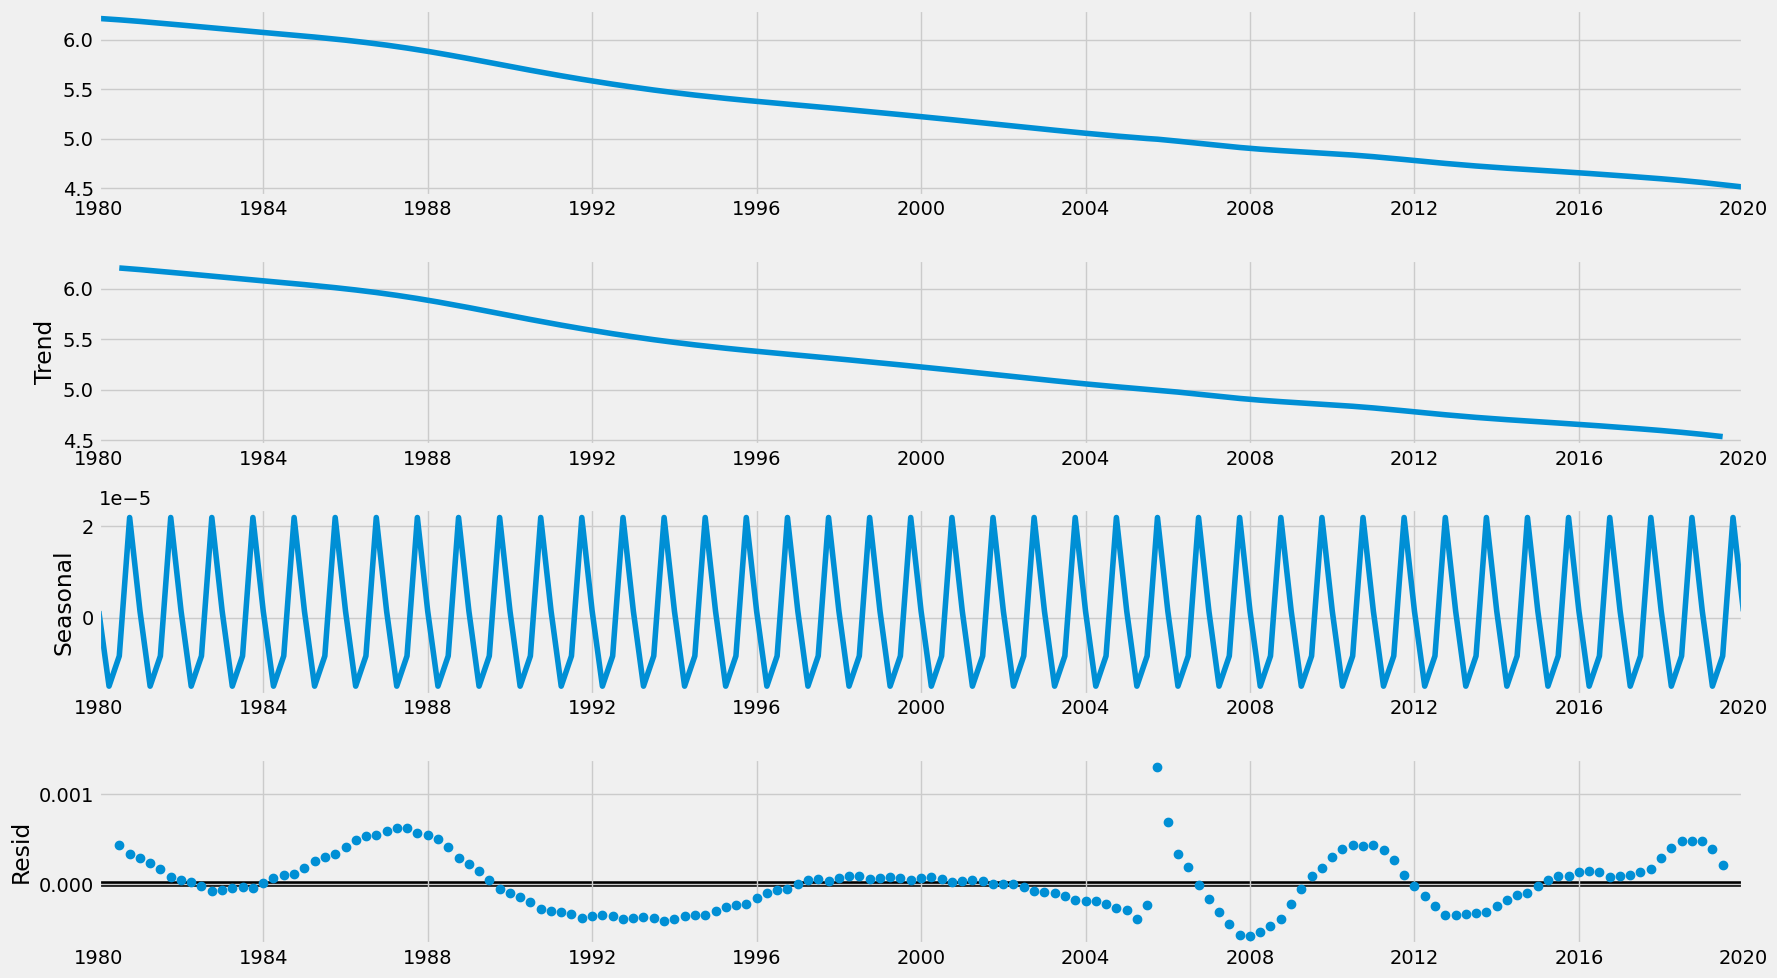

In [20]:
#original data is non-stationary
dickey_fuller(df1)
decomp(df1)

Augmented Dickey-Fuller Test Results:
                              Value
Test Statistic            -2.433725
p-value                    0.132443
Number of Lags             2.000000
Number of Observations   157.000000
Critical Values (1%)      -3.472703
Critical Values (5%)      -2.880132
Critical Values (10%)     -2.576683
IC Best                -1915.649005 

p_value (0.13) is greater than 0.05 and statistically not significant.


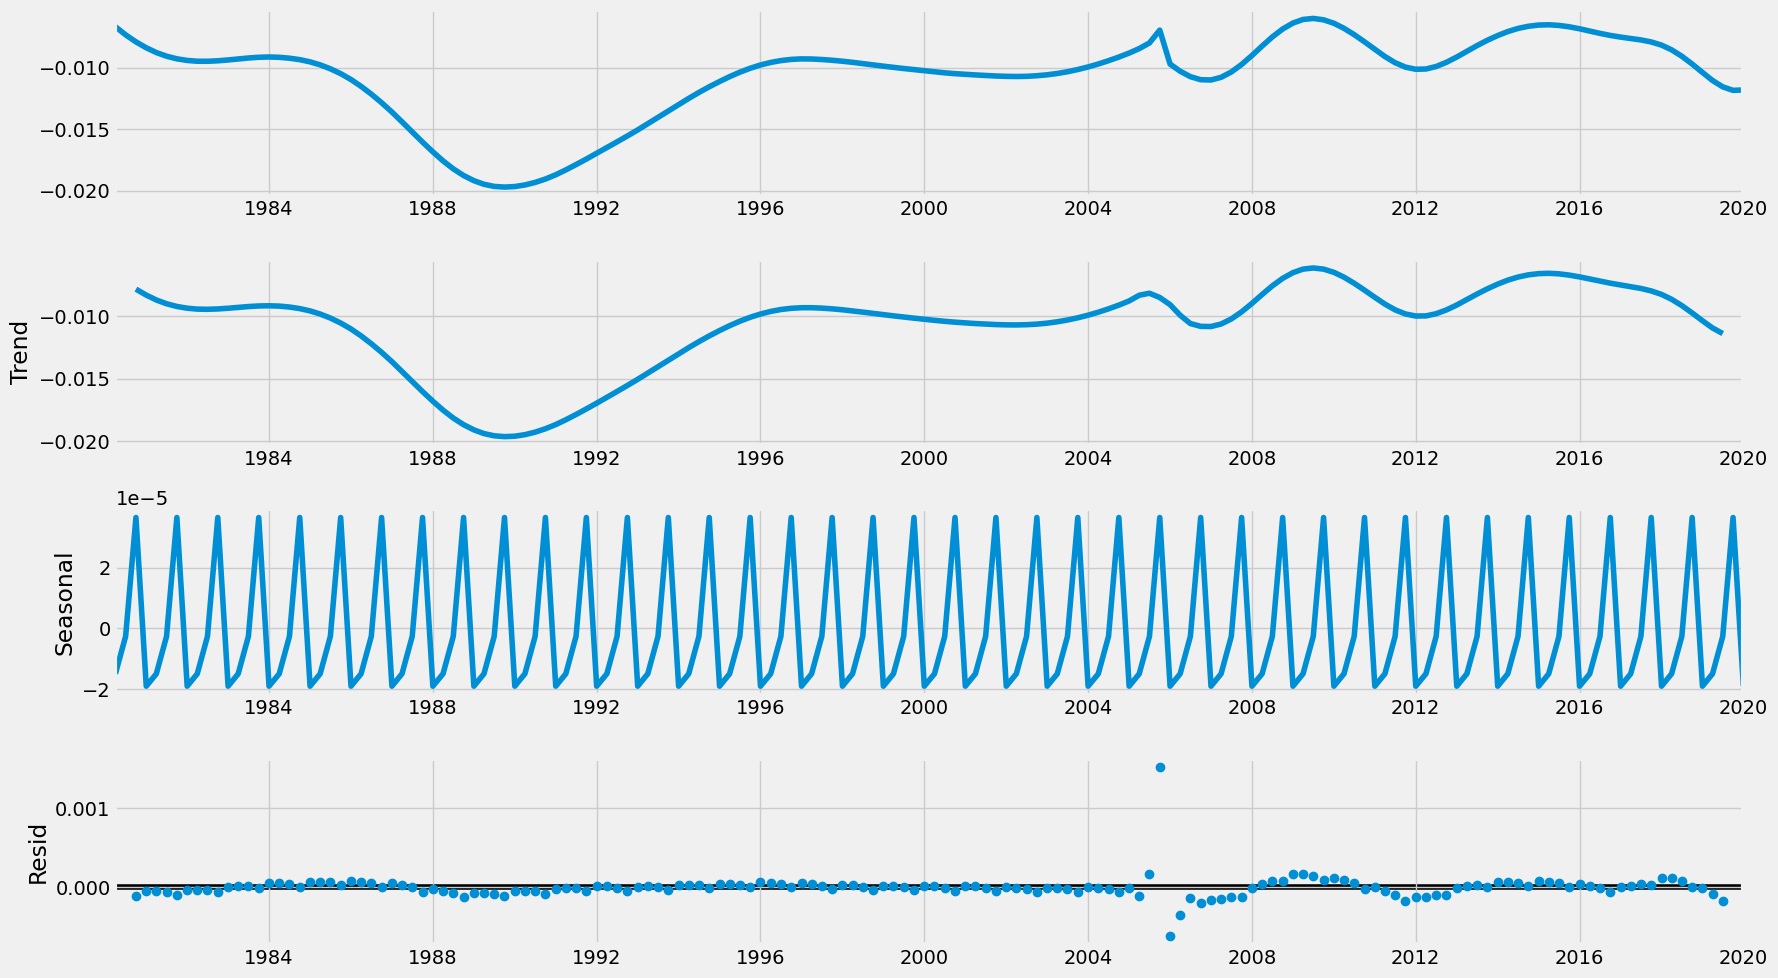

In [21]:
#differenced data
df1_diff = difference(df1)

dickey_fuller(df1_diff)

decomp(df1_diff)

Augmented Dickey-Fuller Test Results:
                              Value
Test Statistic            -3.792606
p-value                    0.002984
Number of Lags             1.000000
Number of Observations   157.000000
Critical Values (1%)      -3.472703
Critical Values (5%)      -2.880132
Critical Values (10%)     -2.576683
IC Best                -1897.493792 

p_value (0.00) is less than 0.05
Test Statistic (-3.79) is less than Critical threshold of 5% (-2.88). 
    
Null Hypothesis -rejected-, data is -stationary-


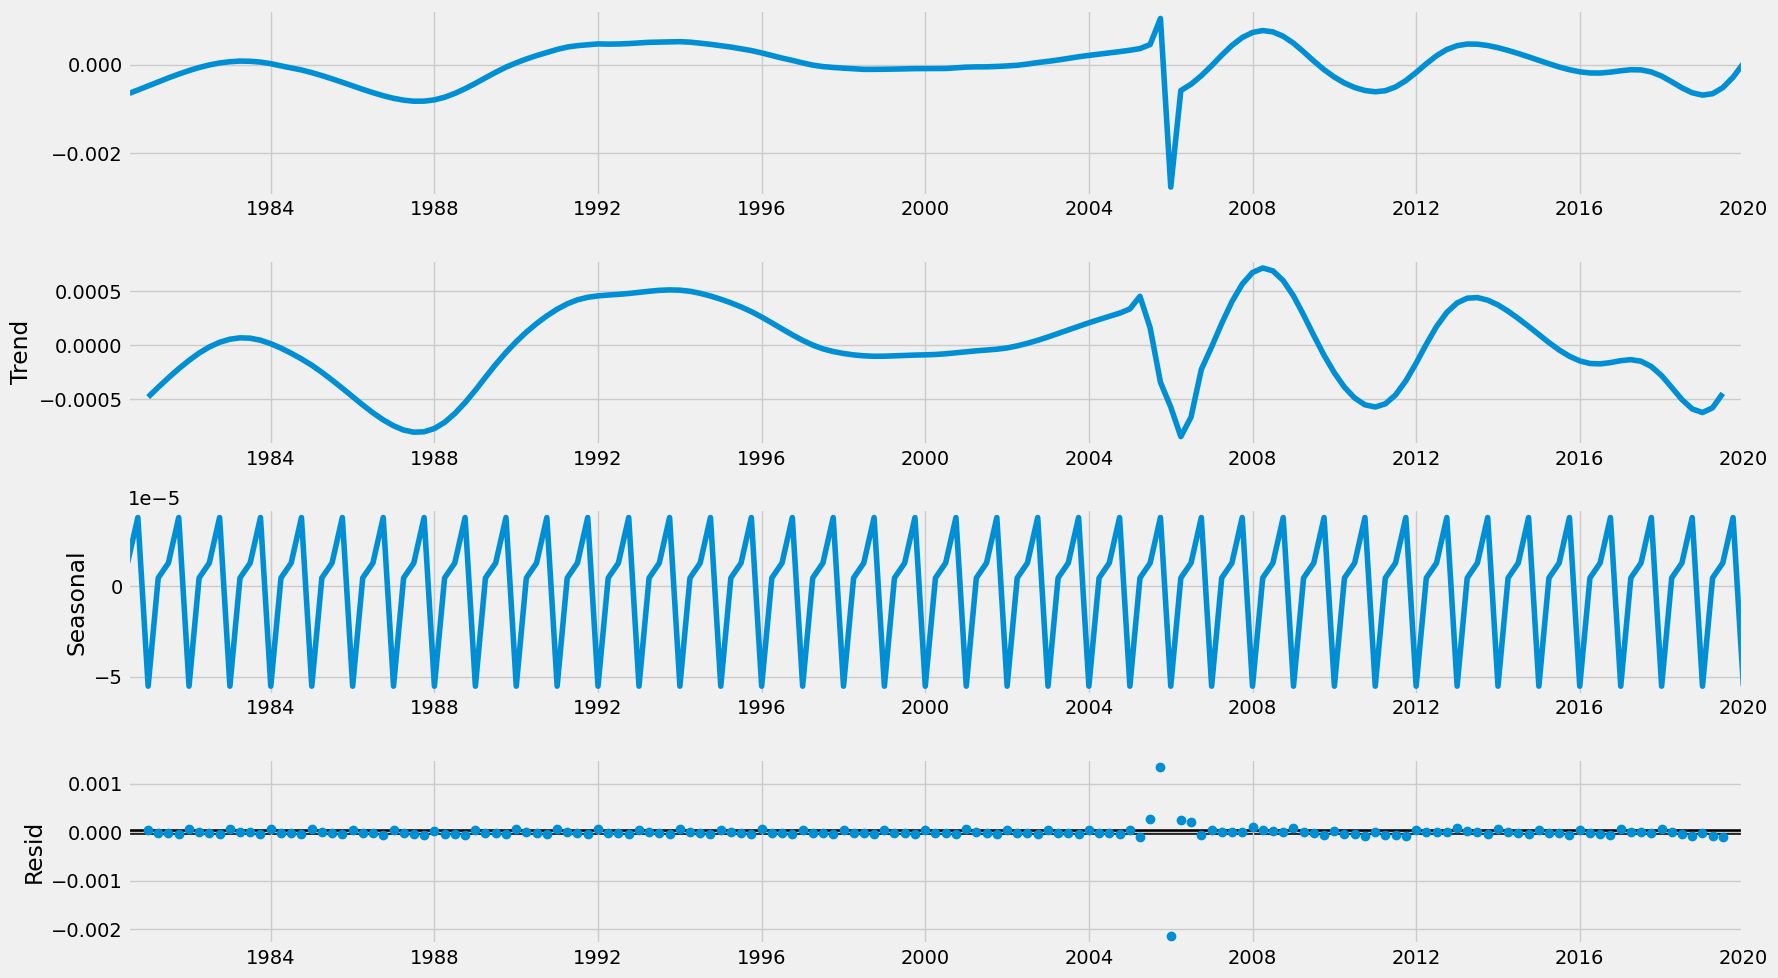

In [22]:
#we are still not stationary, so we'll difference one more time.
df2_diff = difference(df1_diff)

dickey_fuller(df2_diff)
decomp(df2_diff)